In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 4

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:2' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.01,
            'metric' : "DP",
            'lambda': 0.5,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=4_epoch=15_lr=0.001_tau=10.0_alpha=0.01_lmbd_0.5_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([7, 0, 4, ..., 5, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8042726782342893, 'loss': 0.002443575210886926, 'std': 0.05184977074530256, 'EER': -1, 'EO': [0.29132231404958675, 0.4878472222222222], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6104152318640955, 'classwise_accuracy': {0: array([839, 980]), 1: array([ 854, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 496, 1: 559}, 'class_pred_count_s1': {1: 436, 0: 624}, 'class_pred_count': {0: 1120, 1: 995}, 'count_s0': 1055, 'count_s1': 1060, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.8862402229614312, 'loss': 0.0014064845886636289, 'std': 0.021923042344691168, 'EER': -1, 'EO': [0.26736111111111116, 0.18595041322314054], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.7733442378328741, 'classwise_accuracy': {1: array([ 981, 1135]), 0: array([890, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 559, 0: 496}, 'class_pred_count_s1': {0: 548, 1: 512}, 'class_pre

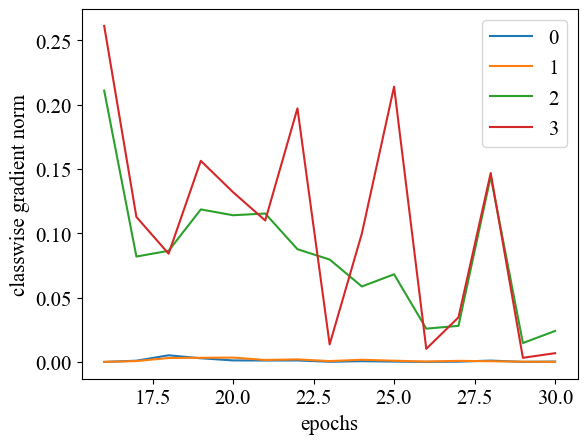

---------------------------- Task 3 -----------------------
losses=tensor([[2.9579e-03, 2.9490e-03, 1.3718e-01, 6.4538e-01, 9.6515e+00, 8.6939e+00,
         2.6381e-02, 2.7893e-02, 1.7232e-01, 5.8996e-01, 8.6379e+00, 9.7038e+00]])
Elapsed time(grad):3.913
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):7.438
Fairness:[-2.69372044e-03  2.71050543e-20  0.00000000e+00 -5.42101086e-20
 -1.57646788e-03  7.10054902e-03]
Current class expected loss:tensor([[ 1.6013,  0.1466, -0.3467,  0.9646,  0.0952, -0.4599,  1.4165,  0.1522,
         -0.3283,  0.9476, -0.0952,  0.4599]])
len(updated_seq_indices)=2048
Elapsed time(etc):0.272
temporal training...
temporal training done
[31] Eval metrics for task 1 >> {'accuracy': 0.9603951272138811, 'loss': 0.000675178933932708, 'std': 0.007972219724894314, 'EER': -1, 'EO': [0.04772060783790988, 0.07612490061617971], 'DP': -1, 'accuracy_s0': 0.9914954700213515, 'accuracy_s1': 0.9295727157943068, 'classwise_accuracy': {0: array([94

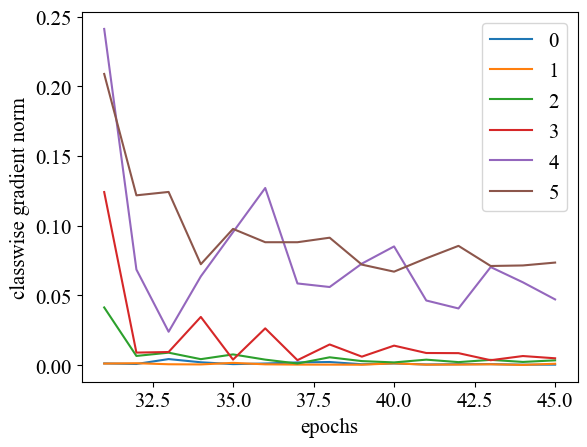

---------------------------- Task 4 -----------------------
losses=tensor([[9.5899e-04, 1.1427e-03, 1.9032e-03, 1.7148e-02, 2.1749e-01, 2.6367e-01,
         1.2112e+01, 7.5297e+00, 1.4342e-02, 1.9295e-02, 1.9788e-02, 4.8785e-02,
         3.7050e-01, 9.4948e-01, 1.0337e+01, 1.0474e+01]])
Elapsed time(grad):4.041
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.393
Fairness:[ 1.35525272e-20  0.00000000e+00 -2.71050543e-20  1.10471707e-03
  6.76863180e-03  1.40457680e-03  0.00000000e+00  2.17696336e-02]
Current class expected loss:tensor([[-1.6932e+00, -1.3546e+00, -2.8529e-01,  4.1536e-01,  1.7808e+00,
         -6.0916e-01,  0.0000e+00, -1.6380e+00, -1.8803e+00, -1.4061e+00,
         -2.7014e-01,  5.7815e-01,  2.7671e+00, -3.4047e-01,  9.5367e-07,
          1.6380e+00]])
len(updated_seq_indices)=2368
Elapsed time(etc):0.176
temporal training...
temporal training done
[46] Eval metrics for task 1 >> {'accuracy': 0.9241256855164974, 'loss': 0.00111503036027822

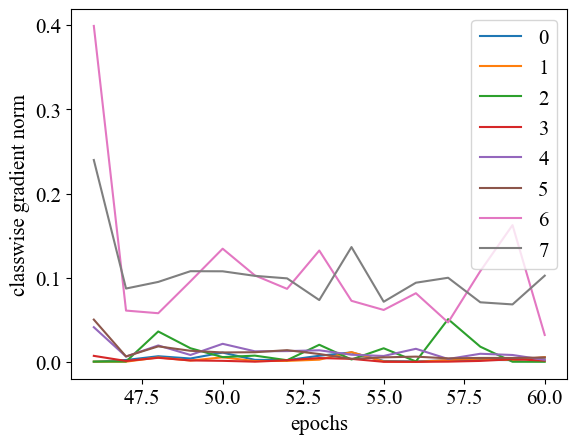

---------------------------- Task 5 -----------------------
losses=tensor([[3.3538e-03, 2.8864e-03, 1.3012e-01, 3.8978e-04, 6.6450e-03, 2.5407e-02,
         1.0145e-01, 1.0731e+00, 9.8076e+00, 1.2714e+01, 1.0763e-01, 2.2123e-02,
         3.9383e-01, 8.3610e-02, 8.0587e-02, 1.0159e-01, 4.1167e-01, 6.2658e-01,
         1.0852e+01, 1.2081e+01]])
Elapsed time(grad):5.354
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.517
Fairness:[-2.91544467e-04 -4.06575815e-20  0.00000000e+00  5.42101086e-20
  2.15221635e-03  2.12291799e-04  0.00000000e+00 -2.06276271e-03
  5.09237396e-03 -7.61268720e-04]
Current class expected loss:tensor([[-1.2645, -1.1802, -1.2019,  0.5703,  1.7293, -0.8912, -0.5814,  0.8259,
         -0.5446,  0.0755, -1.4695, -1.2251, -1.1381,  0.5603,  2.0759, -0.7989,
         -0.5930,  0.4131,  0.5446, -0.0755]])
len(updated_seq_indices)=2752
Elapsed time(etc):0.221
temporal training...
temporal training done
[61] Eval metrics for task 1 >> {'accur

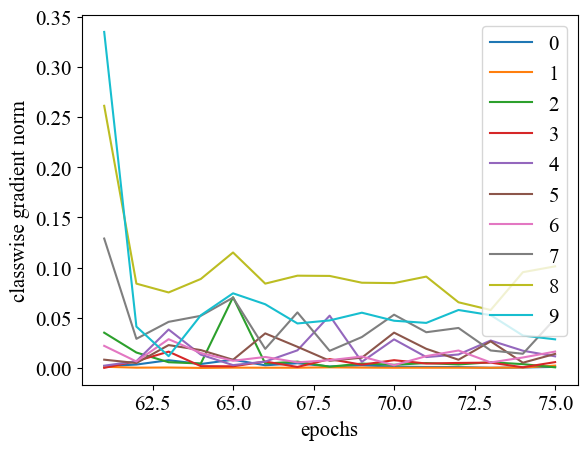

final avg-acc 0.842050672179534
final avg-forget 0.04573105805129937


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")

66.2725	64.494	61.8347	87.1897	
97.5038	111.1169	163.8293	174.9699	
4.1308	3.6265	3.4964	3.2056	
306.7242	292.8408	336.752	371.9855	

In [12]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [13]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()


0.0	0.0122	0.0487	0.0306	0.0101	0.0061	0.0057	0.0007	0.0019	0.0008	0.0002	0.0013	0.003	0.0001	0.0012	0.0534	0.0056	0.0202	0.0068	0.0036	0.0039	0.0067	0.0067	0.0022	0.0032	0.0016	0.0019	0.0019	0.001	0.001	0.0005	0.0043	0.0298	0.0155	0.0257	0.0058	0.006	0.0205	0.0174	0.0026	0.0017	0.0036	0.0053	0.0068	0.0111	0.0006	0.0121	0.0223	0.0166	0.0138	0.0069	0.0084	0.0032	0.0058	0.0036	0.0019	0.0015	0.0006	0.0008	0.0021	
0.0004	0.0063	0.0225	0.0252	0.0231	0.0194	0.0133	0.0028	0.0146	0.0048	0.0014	0.0034	0.0034	0.0006	0.0004	0.0038	0.0026	0.0014	0.0017	0.004	0.0017	0.0011	0.0009	0.0012	0.0035	0.0011	0.0011	0.0015	0.0007	0.0025	0.0019	0.0031	0.0311	0.0182	0.0275	0.0064	0.0045	0.0241	0.0401	0.0029	0.0006	0.0052	0.0134	0.0139	0.0208	0.0074	0.0015	0.0013	0.0004	0.0012	0.0009	0.0011	0.0015	0.001	0.001	0.0007	0.0009	0.0007	0.0011	0.0058	
3.5393	0.6555	0.6549	0.8867	0.76	0.4284	0.4427	0.3423	0.1828	0.2475	0.1139	0.1197	0.1802	0.0546	0.0923	0.2744	0.1233	0.0435	0.0242	0.0383	0.0144	0.0088	0.0419	0.0196	0.

In [14]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()


0.1205	0.1237	0.1879	0.2388	0.118	0.0784	0.0955	0.031	0.0497	0.0071	0.0038	0.0205	0.0235	0.0078	0.0222	0.1014	0.0285	0.1103	0.0744	0.0259	0.0262	0.0298	0.0211	0.0173	0.0205	0.0142	0.0222	0.0258	0.0109	0.0133	0.0102	0.1255	0.0749	0.0789	0.0804	0.1295	0.0466	0.1215	0.0243	0.0322	0.0625	0.0098	0.0278	0.0426	0.0403	0.073	0.0612	0.1368	0.1331	0.0316	0.0228	0.0754	0.0314	0.037	0.0809	0.0093	0.0492	0.0192	0.0067	0.0586	
0.0954	0.1049	0.0944	0.0798	0.0457	0.1193	0.1265	0.0295	0.1542	0.0493	0.01	0.0297	0.0537	0.0136	0.0154	0.0426	0.0718	0.0537	0.0355	0.0593	0.0201	0.0185	0.0612	0.0437	0.0327	0.0162	0.0326	0.0276	0.0224	0.0487	0.0824	0.033	0.0572	0.1075	0.2097	0.0362	0.0505	0.0608	0.297	0.1938	0.0253	0.0313	0.0535	0.1068	0.1913	0.0593	0.0627	0.055	0.1058	0.1252	0.1136	0.0702	0.1577	0.117	0.0245	0.0451	0.0116	0.0245	0.0696	0.0162	
4.4635	1.8807	1.4398	1.1273	1.1278	0.8306	0.8291	1.0714	0.4627	0.6774	0.9343	0.4081	0.3734	1.1896	0.5806	0.3639	0.2166	0.1936	0.1219	0.0716	0.0597	0.0838	0.0741	0.0848	

In [15]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()


1.0164	2.0268	1.8902	2.3774	2.0716	1.1607	1.2326	1.0427	0.6279	0.3693	0.8023	1.1282	0.6158	1.0662	0.8612	1.6013	0.874	1.0654	0.5593	0.7757	0.7289	0.6831	0.7975	0.6334	0.7059	0.7452	0.6562	0.6127	0.6475	0.5984	-1.6932	-0.2954	0.1011	0.335	0.0708	-0.0448	0.362	0.1916	-0.0194	0.0621	0.0778	0.0972	0.1504	0.0873	0.1089	-1.2645	-0.1749	-0.1055	0.0887	-0.3593	0.1116	-0.082	-0.1573	-0.1204	-0.0251	-0.1409	-0.1953	0.0485	-0.3139	-0.0177	
0.0116	1.3031	1.1788	1.2479	1.2323	1.5915	1.3299	1.0937	1.6063	1.2744	0.8635	0.606	0.9674	0.638	0.5947	0.1466	-0.6334	-0.0697	0.0022	-0.0411	0.0165	0.0987	0.0402	0.2328	0.2016	0.2797	0.2029	0.2618	0.5062	0.2874	-1.3546	0.1347	0.4211	0.6531	0.2116	0.1915	0.2522	0.2196	0.4346	0.1986	0.2487	0.5762	0.1963	0.3603	0.3975	-1.1802	-0.1491	0.255	-0.1302	0.0513	0.019	0.0428	0.0117	0.0046	0.0268	0.0009	0.0846	-0.081	0.0256	0.0017	
-0.1235	-0.5855	-0.409	0.0	-0.0525	-0.0	-0.0	-0.4441	-0.0	-0.0	-0.525	-0.0	0.009	-0.8167	-0.2756	-0.3467	1.6867	0.6727	0.5095	0.5733	0.3819	0.7

In [16]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


1.1288	2.0408	1.9913	2.6402	2.2394	1.2657	1.3509	1.158	0.6169	0.3617	0.5611	1.1676	0.6102	1.1573	0.9127	1.4165	0.5692	1.0271	0.5598	0.8614	0.6102	0.7586	0.833	0.6487	0.5343	0.7983	0.7037	0.4723	0.5967	0.5038	-1.8803	0.1764	0.2774	0.372	0.28	0.2229	0.402	0.3196	0.0422	0.1785	0.229	0.2437	0.167	0.0469	0.121	-1.4695	-0.1942	0.2218	0.2785	-0.1218	0.3313	0.0927	0.0002	-0.0238	0.0895	0.0054	-0.0626	0.0757	-0.2402	0.1795	
0.012	1.4028	1.3868	1.3186	1.2971	1.7883	1.4977	1.0467	1.8045	1.3743	0.8964	0.6437	1.0043	0.6623	0.6174	0.1522	-0.2002	0.1241	0.1882	0.0846	0.0171	0.1025	0.0417	0.2416	0.2093	0.2904	0.2106	0.2718	0.5255	0.2984	-1.4061	0.3849	0.5212	0.678	0.3905	0.3252	0.2618	0.3508	0.4396	0.3987	0.1544	0.5981	0.2327	0.374	0.4127	-1.2251	-0.0022	0.0737	0.092	0.0833	-0.0469	0.269	0.0122	0.0048	0.0278	0.0009	0.1712	-0.0841	-0.0475	0.0017	
0.1235	0.5855	0.409	0.0	0.0525	0.0	-0.0	0.4441	-0.0	0.0	0.525	-0.0	-0.009	0.8167	0.2756	-0.3283	1.2632	0.637	0.6039	0.523	0.1811	0.5227	0.3245	0.3175	0.346	0.

In [17]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"DP:{np.mean(metric_manager_callback.meters['DP'].compute_overall())}")
print(f"EO:{np.mean(metric_manager_callback.meters['EO'].compute_overall())}")


accuracy:0.8864692897996254
DP:0.008569348614248153
EO:0.11930753121343463
